In [39]:
from dataLoading import filepath, epoch_and_label_file

import numpy as np
import pandas as pd
import pyxdf

# mne imports
import mne
from mne import io
from mne.datasets import sample

# EEGNet-specific imports
import sys
sys.path.append('/Users/sunniva/Documents/Alcohol_Detection_Project_2023-2024/')
from EEGModels import EEGNet
import tensorflow
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# PyRiemann imports
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

#Sklearn imports
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, GroupKFold
from sklearn.utils import compute_class_weight
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# tools for plotting confusion matrices
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [40]:
subject = "P008"

In [41]:
sessions = 2
runs = [1,3,4,6]
epoch_duration = 5
channels = 16

data_arrays = {}
label_arrays = {}

i = 0
current_label = 'P'
for s in range(sessions):
    for r in runs:
        fname = filepath(subject, s, r)
        epochs_data = epoch_and_label_file(fname, epoch_duration)

        # Determine the label based on session and run
        if s == 1 and r in [3, 4, 6]:
            label = 'A'  # Alcohol
            label_value = 1
        else:
            label = 'P'  # Placebo (Sober)
            label_value = 0
        
        if label != current_label:
            i = 1  # Reset i for the new label series
            current_label = label  # Update the current label
        else:
            i += 1 

        # Create a unique key for each condition and run   
        print(i)
        data_key = f"{label}{i}_X"
        label_key = f"{label}{i}_Y"

        num_of_epochs, _, samples = epochs_data.shape
        data_arrays[data_key] = np.zeros(shape=(num_of_epochs, channels, samples))
        data_arrays[data_key][:] = epochs_data[:, :channels, :]

        label_arrays[label_key] = np.full(shape=(num_of_epochs,), fill_value=label_value)

Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1250 original time points ...
0 bad epochs dropped
1
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1250 original time points ...
0 bad epochs dropped
2
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 1250 original time points ...
0 bad epochs dropped
3
Not setting metadata
61 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 61 events and 1250 original time points ...
0 bad epochs dropped
4
Not setting metadata
62 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 62 events and 1250 original time

In [42]:
X_test = np.vstack([data_arrays['P5_X'], data_arrays['A1_X']]) 
Y_test = np.hstack([label_arrays['P5_Y'], label_arrays['A1_Y']])

X_train = np.vstack([data_arrays['P1_X'], data_arrays['A3_X'], data_arrays['P3_X'], data_arrays['P4_X'], data_arrays['P2_X'], data_arrays['A2_X']])
Y_train = np.hstack([label_arrays['P1_Y'], label_arrays['A3_Y'], label_arrays['P3_Y'], label_arrays['P4_Y'], label_arrays['P2_Y'], label_arrays['A2_Y']])

In [43]:
kernels, chans, samples = 1, 16, 1250

model = EEGNet(nb_classes = 1, Chans = chans, Samples = samples, 
               dropoutRate = 0.50, kernLength = 125, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [44]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0], -1)).reshape(X_test.shape)

randomize_train = np.arange(len(X_train))
np.random.shuffle(randomize_train)
X_train = X_train[randomize_train]
Y_train = Y_train[randomize_train]

randomize_test = np.arange(len(X_test))
np.random.shuffle(randomize_train)
X_test = X_test[randomize_test]
Y_test = Y_test[randomize_test]

In [45]:
X_train  = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_test  = X_test.reshape(X_test.shape[0], chans, samples, kernels)

In [46]:
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 15)

Epoch 1/15
24/24 [==============================] - 3s 87ms/step - loss: 0.2647 - accuracy: 0.9730
Epoch 2/15
24/24 [==============================] - 2s 87ms/step - loss: 0.0541 - accuracy: 1.0000
Epoch 3/15
24/24 [==============================] - 2s 86ms/step - loss: 0.0441 - accuracy: 1.0000
Epoch 4/15
24/24 [==============================] - 2s 84ms/step - loss: 0.0414 - accuracy: 1.0000
Epoch 5/15
24/24 [==============================] - 2s 85ms/step - loss: 0.0321 - accuracy: 0.9973
Epoch 6/15
24/24 [==============================] - 2s 86ms/step - loss: 0.0292 - accuracy: 1.0000
Epoch 7/15
24/24 [==============================] - 2s 85ms/step - loss: 0.0239 - accuracy: 1.0000
Epoch 8/15
24/24 [==============================] - 2s 86ms/step - loss: 0.0253 - accuracy: 1.0000
Epoch 9/15
24/24 [==============================] - 2s 89ms/step - loss: 0.0165 - accuracy: 1.0000
Epoch 10/15
24/24 [==============================] - 2s 87ms/step - loss: 0.0250 - accuracy: 1.0000
Epoch 11/

4/4 [==============================] - 0s 20ms/step


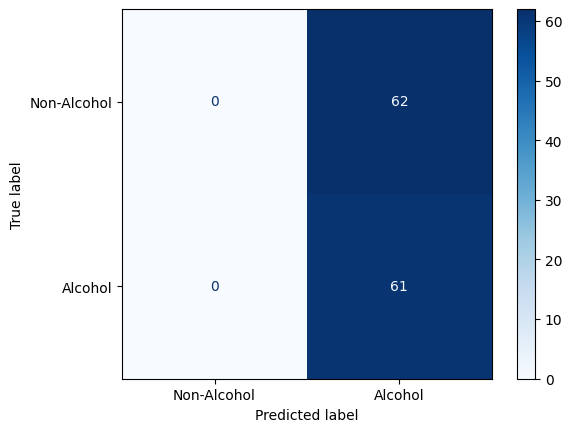

The accuracy of the model with cross validation is 0.49593496322631836
The precision score of the model with cross validation is 0.4959349593495935
The recall score of the model with cross validation is 1.0
The F1 score of the model with cross validation is 0.6630434782608696
The specificity score of the model with cross validation is 0.0


In [48]:
score = model.evaluate(X_test, Y_test)

pred_val = model.predict(X_test)
pred_val = np.where(pred_val > 0.5, 1, 0)

labels = ["Non-Alcohol", "Alcohol"]
cm = confusion_matrix(Y_test, pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

tn, fp, fn, tp = cm.ravel()

accuracy = score[1]
F1_score = f1_score(y_true=Y_test, y_pred=pred_val)
precision= precision_score(y_true=Y_test, y_pred=pred_val)
recall = recall_score(y_true=Y_test, y_pred=pred_val)
specificity = tn/(tn+fp)

print("The accuracy of the model with cross validation is", accuracy)
print("The precision score of the model with cross validation is", precision)
print("The recall score of the model with cross validation is", recall)
print("The F1 score of the model with cross validation is", F1_score)
print("The specificity score of the model with cross validation is", specificity)

In [ ]:
# num_folds = 3

# kf = KFold(n_splits=num_folds)

# accuracy = np.zeros(num_folds)
# F1_score = np.zeros(num_folds)
# precision = np.zeros(num_folds)
# recall = np.zeros(num_folds)
# specificity = np.zeros(num_folds)

# # X_training = np.concatenate(X_training, axis=0)
# # Y_training = np.concatenate(Y_training, axis=0)

# #Scale the data
# scaler = StandardScaler()
# #X_train_scaled = scaler.fit_transform(X_training.reshape(X_training.shape[0], -1)).reshape(X_training.shape)
# X_training_concatenated = np.vstack(X_training)
# scaler.fit(X_training_concatenated.reshape(X_training_concatenated.shape[0], -1))
# X_test_scaled = scaler.transform(X_testing.reshape(X_testing.shape[0], -1)).reshape(X_testing.shape)


# for i, (train_index, val_index) in enumerate(kf.split(X_training, Y_training)):
#     print(train_index)
#     print(val_index)
#     #Splitting the training data into training and validation
#     X_train_fold = np.vstack([X_training[train_index[0]], X_training[train_index[1]], X_training[train_index[2]], X_training[train_index[3]]])
#     y_train_fold = np.hstack([Y_training[train_index[0]], Y_training[train_index[1]], Y_training[train_index[2]], Y_training[train_index[3]]])
   
#     X_val_fold = np.vstack([X_training[val_index[0]], X_training[val_index[1]]])
#     y_val_fold = np.hstack([Y_training[val_index[0]], Y_training[val_index[1]]])

#     X_train_fold = scaler.transform(X_train_fold.reshape(X_train_fold.shape[0], -1)).reshape(X_train_fold.shape)
#     X_val_fold = scaler.transform(X_val_fold.reshape(X_val_fold.shape[0], -1)).reshape(X_val_fold.shape)
    
#     #Shuffling the data
#     randomize_train = np.arange(len(X_train_fold))
#     np.random.shuffle(randomize_train)
#     print(randomize_train)
#     X_train_fold = X_train_fold[randomize_train]
#     print(X_train_fold)
#     y_train_fold = y_train_fold[randomize_train]

#     randomize_val = np.arange(len(X_val_fold))
#     np.random.shuffle(randomize_val)
#     X_val_fold = X_val_fold[randomize_val]
#     y_val_fold = y_val_fold[randomize_val]

#     #Reshape for the model
#     X_train_fold = X_train_fold.reshape(X_train_fold.shape[0], channels, samples, kernels)
#     X_val_fold = X_val_fold.reshape(X_val_fold.shape[0], channels, samples, kernels)

#     #Train the model
#     fittedModel = model.fit(X_train_fold, y_train_fold, batch_size = 32, epochs = 15, validation_data=(X_val_fold, y_val_fold))
    
#     # Evaluate the model
#     scores = model.evaluate(X_val_fold, y_val_fold)
#     print(f'Score for fold: {scores}')

#     # Predictions and metrics
#     y_pred_fold = model.predict(X_val_fold)
#     y_pred_fold = np.where(y_pred_fold > 0.5, 1, 0)

#     # #Plotting confusion matrix
#     labels = ["Non-Alcohol", "Alcohol"]
#     cm = confusion_matrix(y_val_fold, y_pred_fold, labels=[0,1])
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     disp.plot(cmap=plt.cm.Blues)
#     plt.title(f'Confusion Matrix for Fold {i+1}')
#     plt.show()
        
#     tn, fp, fn, tp = cm.ravel()

#     # Assign metrics to numpy array for the current fold
#     accuracy[i] = accuracy_score(y_val_fold, y_pred_fold)
#     F1_score[i] = f1_score(y_val_fold, y_pred_fold)
#     precision[i] = precision_score(y_val_fold, y_pred_fold)
#     recall[i] = recall_score(y_val_fold, y_pred_fold)
#     specificity[i] = tn / (tn + fp)

#     # Print metrics
#     print(f"Validation Accuracy: {accuracy[i]}")
#     print(f"Validation Precision: {precision[i]}")
#     print(f"Validation Recall: {recall[i]}")
#     print(f"Validation F1 Score: {F1_score[i]}")

#     #How many occurances appear in the train set
#     unique_train, counts_train = np.unique(y_train_fold, return_counts=True)
#     unique_test, counts_test = np.unique(y_val_fold, return_counts=True)


# standard_deviation = np.std(accuracy)

# print("The accuracy of the model with cross validation is", accuracy.mean())
# print("The precision score of the model with cross validation is", precision.mean())
# print("The recall score of the model with cross validation is", recall.mean())
# print("The F1 score of the model with cross validation is", F1_score.mean())
# print("The specificity score of the model with cross validation is", specificity.mean())
# print("The standard deviation of the accuracy of the model with cross validation is", standard_deviation)